# Import modules 

In [1]:
# for pre-processing data
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# for create dataset
from torchvision import datasets
from torch.utils.data import DataLoader
import torchvision.transforms as T

In [3]:
# for create model
import random
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torchvision import models
import time
import copy

# Set params 

In [4]:
# reproduce random
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)

In [5]:
# cuDNN
torch.backends.cudnn.enabled = True
torch.backends.cudnn.deterministic = False

In [6]:
# GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
print(device)

cuda:0


# Pre-pocessing data 

In [7]:
transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5,), (0.5,))
])

In [8]:
# upload training dataset
MNIST_train = datasets.MNIST("./data", download=False, train=True, transform=transform)
train_loader = DataLoader(MNIST_train, batch_size=64, shuffle=True)
x_train = MNIST_train.train_data
y_train = MNIST_train.train_labels

C:\Users\alekselion\miniconda3\lib\site-packages\torchvision\datasets\mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
C:\Users\alekselion\miniconda3\lib\site-packages\torchvision\datasets\mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [9]:
# upload test dataset
MNIST_test = datasets.MNIST("./data", download=False, train=False, transform=transform)
test_loader = DataLoader(MNIST_test, batch_size=64, shuffle=True)
x_test = MNIST_test.test_data.to(device)
y_test = MNIST_test.test_labels.to(device)

C:\Users\alekselion\miniconda3\lib\site-packages\torchvision\datasets\mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
C:\Users\alekselion\miniconda3\lib\site-packages\torchvision\datasets\mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [10]:
# normalize
x_train = x_train / 255.0
x_test = x_test / 255.0

In [11]:
# amount of numbers
print("Train".rjust(8) + "Test".rjust(5))
for i in range(10):
    print(f"{i}  {len(y_train[y_train == i])}  {len(y_test[y_test == i])}")

   Train Test
0  5923  980
1  6742  1135
2  5958  1032
3  6131  1010
4  5842  982
5  5421  892
6  5918  958
7  6265  1028
8  5851  974
9  5949  1009


# Show images  

In [12]:
labels = {
    0: 'zero', 
    1: 'one', 
    2: 'two', 
    3: 'three', 
    4: 'four', 
    5: 'five', 
    6: 'six', 
    7: 'seven', 
    8: 'eight', 
    9: 'nine'
}

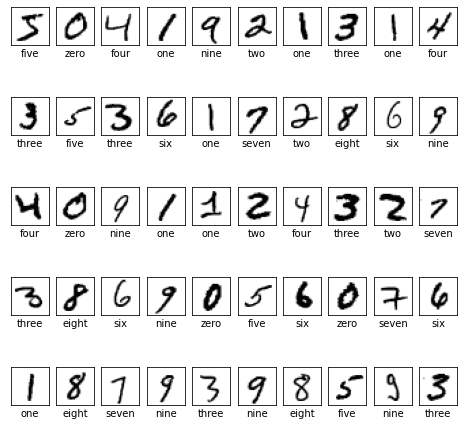

In [13]:
img = x_train.reshape(-1, 28, 28)
plt.figure(figsize=(8, 8))
for i in range(50):
    plt.subplot(5, 10, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img[i], cmap=plt.cm.binary)
    plt.xlabel(labels[int(y_train[i])])
plt.show()

# Create model

In [14]:
class Net(nn.Module):
    def __init__(self, hid1, hid2):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, hid1)
        self.fc2 = nn.Linear(hid1, hid2)
        self.fc3 = nn.Linear(hid2, 10)
        self.drop = nn.Dropout(0.2)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = F.relu(self.fc2(x))
        x = self.drop(x)
        x = F.softmax(self.fc3(x), dim=1)
        return x
    
    def fit(self, x, y, epochs=1, batch_size=1, valid_size=1):
        history = {"train_loss":[], "valid_loss":[], "train_acc":[], "valid_acc":[]}
        best_model_wts = copy.deepcopy(model.state_dict())
        best_acc = 0.0
        
        # create a validation dataset 
        order = np.random.permutation(int(len(x) * valid_size))
        x_valid = x[order].to(device)
        y_valid = y[order].to(device)
        
        # delete the validation data from the training dataset 
        x = x[~order].to(device)
        y = y[~order].to(device)
        
        start_training = time.time()
        
        for epoch in range(1, epochs + 1):
            print(f"Epoch: {epoch}/{epochs}")
            print("-" * 12)
            
            # shuffle dataset
            order = np.random.permutation(len(x))

            for start_index in range(0, len(x), batch_size):
                model.train()
                
                # create a batches
                batch_indexes = order[start_index:start_index+batch_size]
                x_batch = x[batch_indexes]
                y_batch = y[batch_indexes]
                
                optimizer.zero_grad()
                
                # forward propagate
                pred = model.forward(x_batch)
                loss = criterion(pred, y_batch)
                
                # gradient descent
                loss.backward()
                optimizer.step()
            
            model.eval()
            with torch.no_grad():
                # loss and accuracy of the training data
                train_preds = model.forward(x)
                train_loss = criterion(train_preds, y).float().mean().data.cpu()
                train_acc = (train_preds.argmax(dim=1) == y).float().mean().data.cpu()
                history["train_loss"].append(train_loss)
                history["train_acc"].append(train_acc)
                
                # loss and accuracy of the validation dataorward(x_valid)
                valid_preds = model.forward(x_valid)
                valid_loss = criterion(valid_preds, y_valid).float().mean().data.cpu()
                valid_acc = (valid_preds.argmax(dim=1) == y_valid).float().mean().data.cpu()
                history["valid_loss"].append(valid_loss)
                history["valid_acc"].append(valid_acc)
                
                if valid_acc > best_acc:
                    best_acc = valid_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
            
            print(f"Train => Loss: {train_loss :.5f}\tAccuracy: {train_acc :.5f}")
            print(f"Valid => Loss: {valid_loss :.5f}\tAccuracy: {valid_acc :.5f}\n")

        finish_training = time.time() - start_training
        
        print("Training completed".center(10, "*"))
        print(f"Time: {int(finish_training // 60)}m {int(finish_training % 60)}s")
        print(f"Best accuracy: {best_acc :.5f}")
        model.load_state_dict(best_model_wts)
        
        return model, history

    def evaluate(self, x, y):
        model.eval()
        with torch.no_grad():
            test_preds = model.forward(x)
            test_loss = criterion(test_preds, y).float().mean().data.cpu()
            test_acc = (test_preds.argmax(dim=1) == y).float().mean().data.cpu()

        return test_loss, test_acc

In [29]:
model = Net(100, 80).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

model, his = model.fit(x=x_train, y=y_train, epochs=80, batch_size=10, valid_size=0.2)
torch.cuda.empty_cache()

Epoch: 1/80
------------
Train => Loss: 1.55652	Accuracy: 0.91175
Valid => Loss: 1.57179	Accuracy: 0.89575

Epoch: 2/80
------------
Train => Loss: 1.53287	Accuracy: 0.93175
Valid => Loss: 1.55117	Accuracy: 0.91425

Epoch: 3/80
------------
Train => Loss: 1.52674	Accuracy: 0.93750
Valid => Loss: 1.54902	Accuracy: 0.91333

Epoch: 4/80
------------
Train => Loss: 1.51261	Accuracy: 0.95033
Valid => Loss: 1.53843	Accuracy: 0.92383

Epoch: 5/80
------------
Train => Loss: 1.50354	Accuracy: 0.95900
Valid => Loss: 1.52720	Accuracy: 0.93475

Epoch: 6/80
------------
Train => Loss: 1.50053	Accuracy: 0.96242
Valid => Loss: 1.52233	Accuracy: 0.93975

Epoch: 7/80
------------
Train => Loss: 1.49535	Accuracy: 0.96658
Valid => Loss: 1.51759	Accuracy: 0.94408

Epoch: 8/80
------------
Train => Loss: 1.49651	Accuracy: 0.96542
Valid => Loss: 1.52209	Accuracy: 0.93842

Epoch: 9/80
------------
Train => Loss: 1.49320	Accuracy: 0.96825
Valid => Loss: 1.51766	Accuracy: 0.94417

Epoch: 10/80
------------
Tr

Train => Loss: 1.47408	Accuracy: 0.98708
Valid => Loss: 1.50619	Accuracy: 0.95475

Epoch: 78/80
------------
Train => Loss: 1.47299	Accuracy: 0.98808
Valid => Loss: 1.50733	Accuracy: 0.95375

Epoch: 79/80
------------
Train => Loss: 1.47222	Accuracy: 0.98883
Valid => Loss: 1.50419	Accuracy: 0.95675

Epoch: 80/80
------------
Train => Loss: 1.47430	Accuracy: 0.98667
Valid => Loss: 1.50944	Accuracy: 0.95133

Training completed
Time: 1m 50s
Best accuracy: 0.95842


Test loss: 1.500


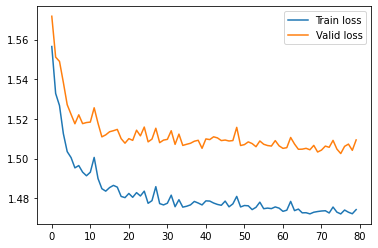

In [30]:
model.eval()
with torch.no_grad():
    evaluate = model.evaluate(x_test, y_test)


print(f"Test loss: {evaluate[0] :.3f}")
plt.plot(his["train_loss"], label="Train loss")
plt.plot(his["valid_loss"], label="Valid loss")
plt.legend()
plt.show()

Test accuracy: 96.11%


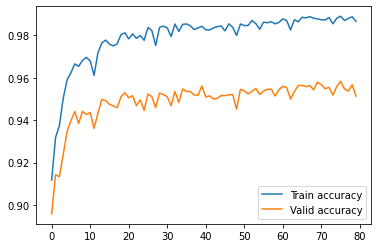

In [31]:
model.eval()
with torch.no_grad():
    evaluate = model.evaluate(x_test, y_test)

print(f"Test accuracy: {(evaluate[1] * 100) :.2f}%")    
plt.plot(his["train_acc"], label="Train accuracy")
plt.plot(his["valid_acc"], label="Valid accuracy")
plt.legend()
plt.show()

## Test model

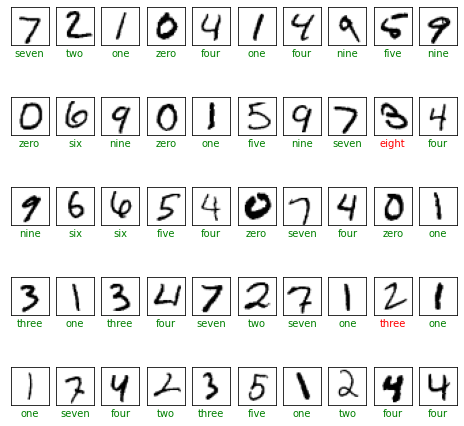

In [32]:
img = x_test.reshape(-1, 28, 28).cpu()
plt.figure(figsize=(8, 8))
for i in range(50):
    model.eval()
    x = x_test[i]
    y = (model.forward(x)).argmax(dim=1)
    color = "red" if y != y_test[i] else "green"

    plt.subplot(5, 10, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img[i], cmap=plt.cm.binary)
    plt.xlabel(labels[int(y)], color=color)
plt.show()

In [33]:
# compute confusion matrix
tp, fp, fn, tn = 0, 0, 0, 0
for i in range(len(x_test)):
    if model.forward(x_test[i]).argmax(dim=1) and y_test[i]:
        tp += 1
    elif model.forward(x_test[i]).argmax(dim=1) and not y_test[i]:
        fp += 1
    elif not model.forward(x_test[i]).argmax(dim=1) and y_test[i]:
        fn += 1
    elif not model.forward(x_test[i]).argmax(dim=1) and not y_test[i]:
        tn += 1
        
confusion_matrix = np.array([[tp, fp], [fn, tn]])

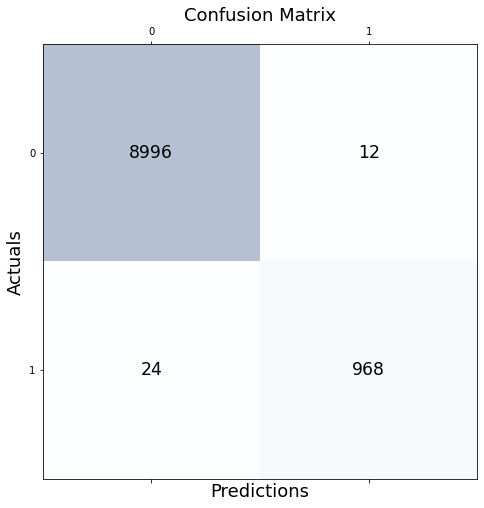

In [34]:
# show confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
ax.matshow(confusion_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        ax.text(x=j, y=i, s=confusion_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [35]:
# calculate errors
model.eval()
with torch.no_grad():
    preds = model.forward(x_test).argmax(dim=1)
    mask = preds == y_test
    x_false = x_test[~mask]  # изображения, на которых ИНС ошибается
    y_false = preds[~mask]  # ошибочные предсказания ИНС
    
print(f"Number of errors: {x_false.shape[0]} of {x_test.shape[0]}")
torch.cuda.empty_cache()

Number of errors: 389 of 10000


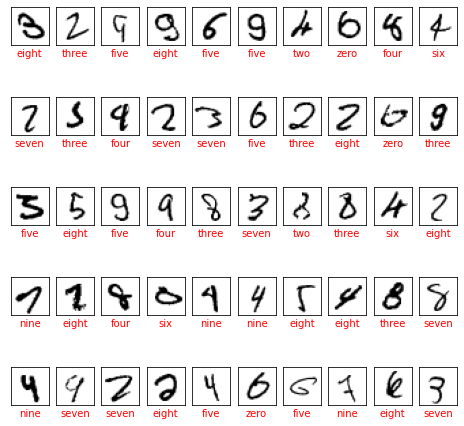

In [36]:
img = x_false.reshape(-1, 28, 28).cpu()
plt.figure(figsize=(8, 8))
for i in range(50):
    model.eval()
    x = x_false[i]
    y = (model.forward(x)).argmax(dim=1)

    plt.subplot(5, 10, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img[i], cmap=plt.cm.binary)
    plt.xlabel(labels[int(y)], color="red")
plt.show()

# Save model 

In [37]:
torch.save(model.state_dict(), os.path.join(os.getcwd(), "models/model_ffnn.pth"))